# Observe reconstruction fidelity

In [110]:
import os
import random
import re
import sys
from datetime import datetime
from random import sample

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.preprocessing import StandardScaler
from torch.autograd import Variable
from torch.distributions.kl import kl_divergence
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import DataLoader, Dataset

# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torchvision.utils import save_image

In [3]:
path = "/Users/M283455/VAE_prject/scripts/"
sys.path.insert(0, path)

In [4]:
import VAE_tybalt
from VAE_tybalt import VAE

In [5]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [6]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

Load data

In [7]:
tcga_tybalt_file_location = "../../VAE_prject_data/raw/rnaseq_df_test.csv"
rnaseq_df = pd.read_csv(tcga_tybalt_file_location)
rnaseq_df.drop(columns=rnaseq_df.columns[0], axis=1, inplace=True)
rnaseq_df = rnaseq_df.dropna()

Compute reconstruction losses

### Compare models trained with noisy datasets

In [12]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

In [13]:
model.load_state_dict(torch.load("../output/models/vae_weights.pth"))

<All keys matched successfully>

## Results

In [375]:
# load model
def load_trained_model(model, model_name):
    model.load_state_dict(torch.load("../output/models/" + model_name))
    return model


# reconstruct the input dataframe with VAE
def VAE_reconstruct_df(df, model):
    reconstruct_tensor = model.forward(torch.tensor(df.values, dtype=torch.float32))[0]
    dataframe = pd.DataFrame(reconstruct_tensor.detach().numpy(), columns=df.columns)

    return dataframe


# How well does the model reconstruct the input RNAseq data
def VAE_latent_out(df):
    mu = model.forward(torch.tensor(df.values, dtype=torch.float32))[2]
    sigma = model.forward(torch.tensor(df.values, dtype=torch.float32))[3]

    column_names = [str(i) for i in range(100)]

    mu = pd.DataFrame(mu.detach().numpy(), columns=column_names)
    sigma = pd.DataFrame(sigma.detach().numpy(), columns=column_names)

    return mu, sigma


def gene_summary(df, df_reconstruct):
    reconstruction_fidelity = df - df_reconstruct

    gene_mean = reconstruction_fidelity.mean(axis=0)
    gene_abssum = reconstruction_fidelity.abs().sum(axis=0).divide(rnaseq_df.shape[0])
    gene_summary = pd.DataFrame(
        [gene_mean, gene_abssum], index=["gene mean", "gene abs(sum)"]
    ).T
    gene_summary = gene_summary.sort_values(by="gene abs(sum)", ascending=True)

    return gene_summary


# plot histograms for the genes which have best recontructions
def plot_histograms_best_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[70 + i]],
            bins=100,
            alpha=0.22,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[70 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "reconstructed"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/reconstructed_best_genes.png")

    # Show the plot
    plt.show()


# plot histograms for the genes which have best recontructions
def plot_histograms_worst_genes(df, model):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    worst_500_genes = list(gene_summary_sort.index[-500:])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.7,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(worst_500_genes[460+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "reconstructed"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()

    plt.savefig("../output/figures/reconstructed_worst_genes.png")
    plt.show()

In [376]:
%ls ../output/figures/

In [293]:
models = os.listdir("../output/models/")
print(models)

['65vae_weights.pth', 'tcga_rnaseq_df_0p20vae_weights.pth', 'tcga_rnaseq_df_0p100vae_weights.pth', 'vae_weights.pth', 'tcga_rnaseq_df_0p40vae_weights.pth', 'tcga_rnaseq_df_0p1vae_weights.pth', 'tcga_rnaseq_df_0p60vae_weights.pth', 'tcga_rnaseq_df_0p80vae_weights.pth']


In [294]:
model = VAE(input_dim=5000, hidden_dim=[100], z_dim=100)

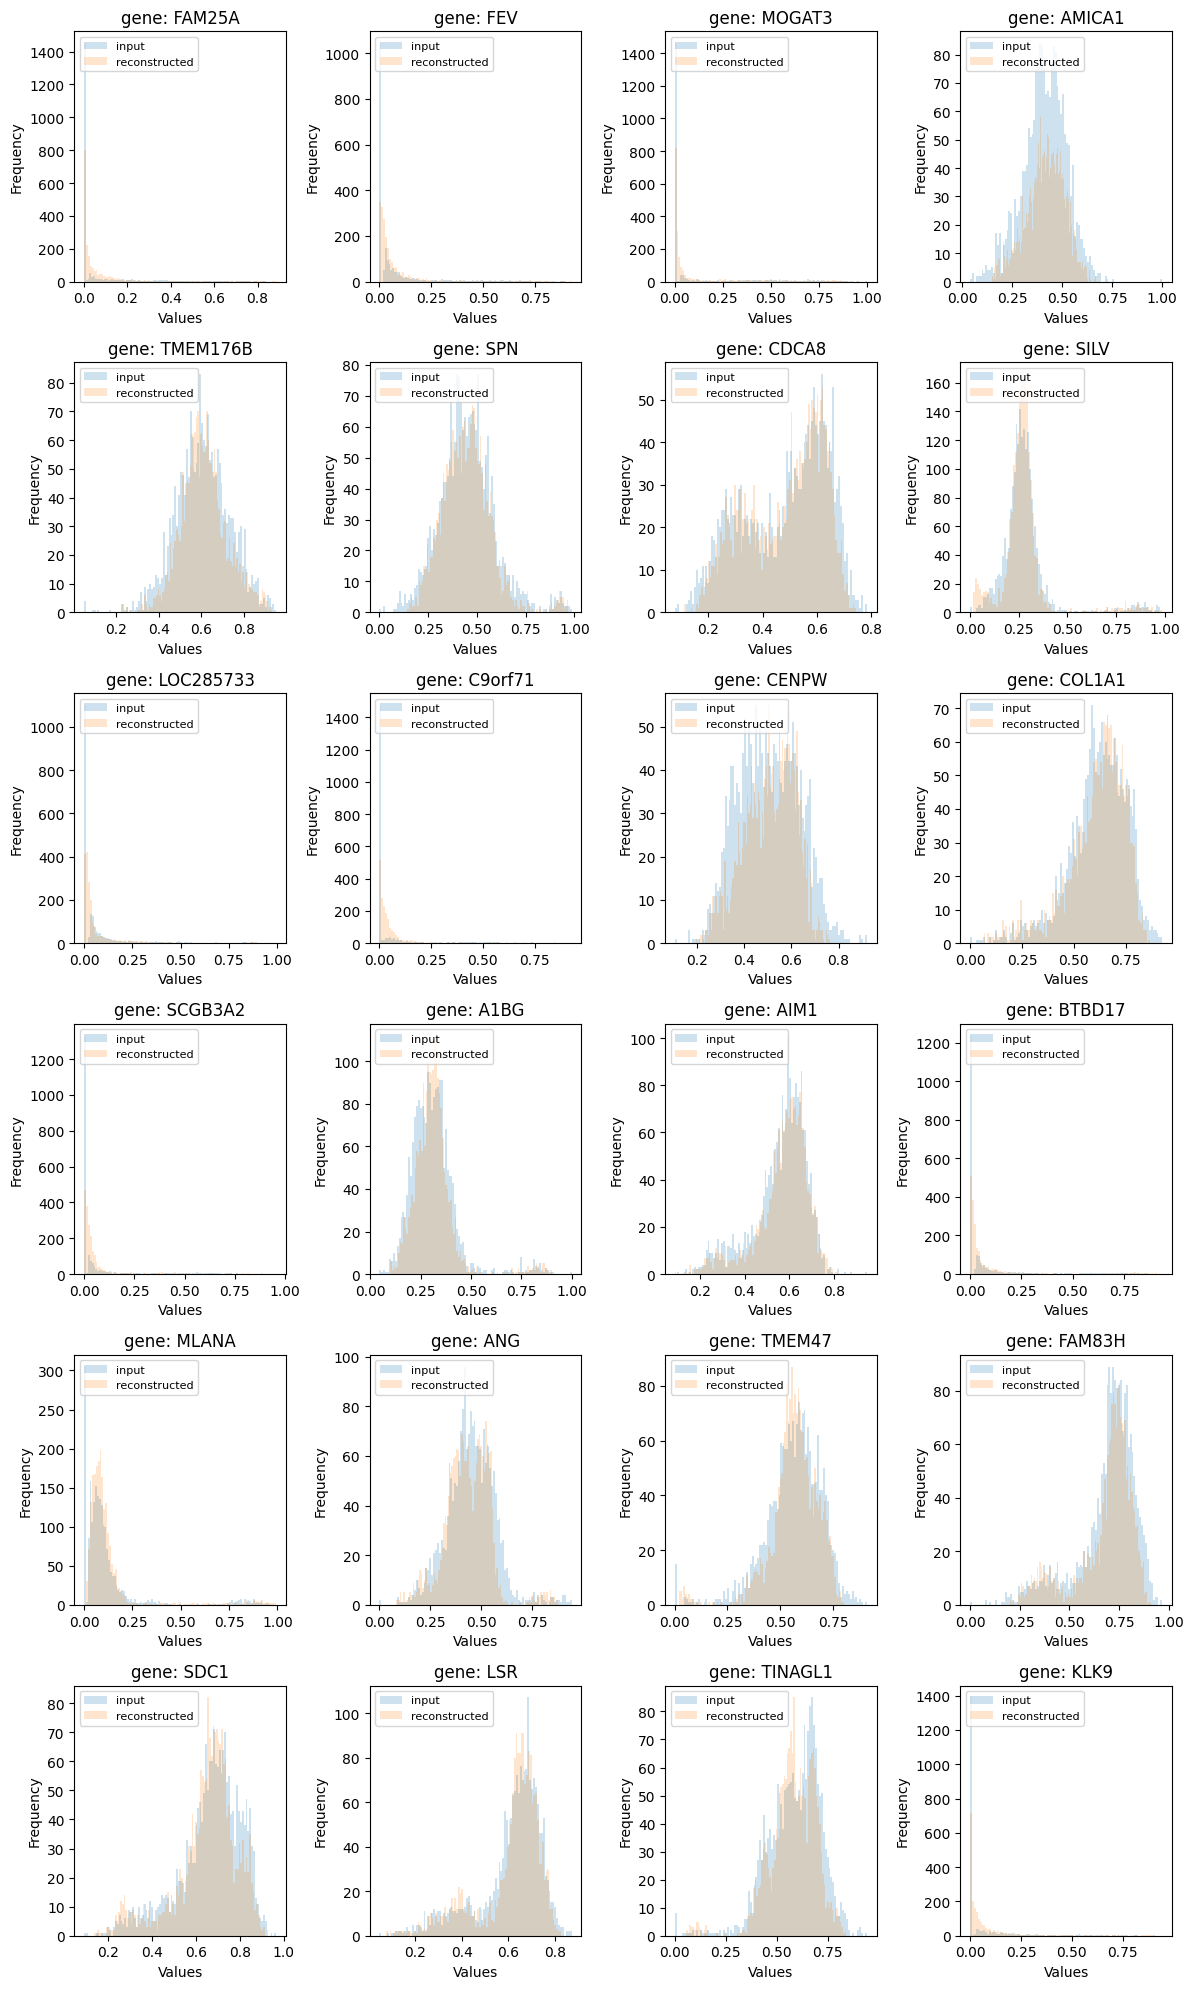

In [377]:
# gene with good reconstruction
model = load_trained_model(model, model_name=models[3])
plot_histograms_best_genes(rnaseq_df, model)

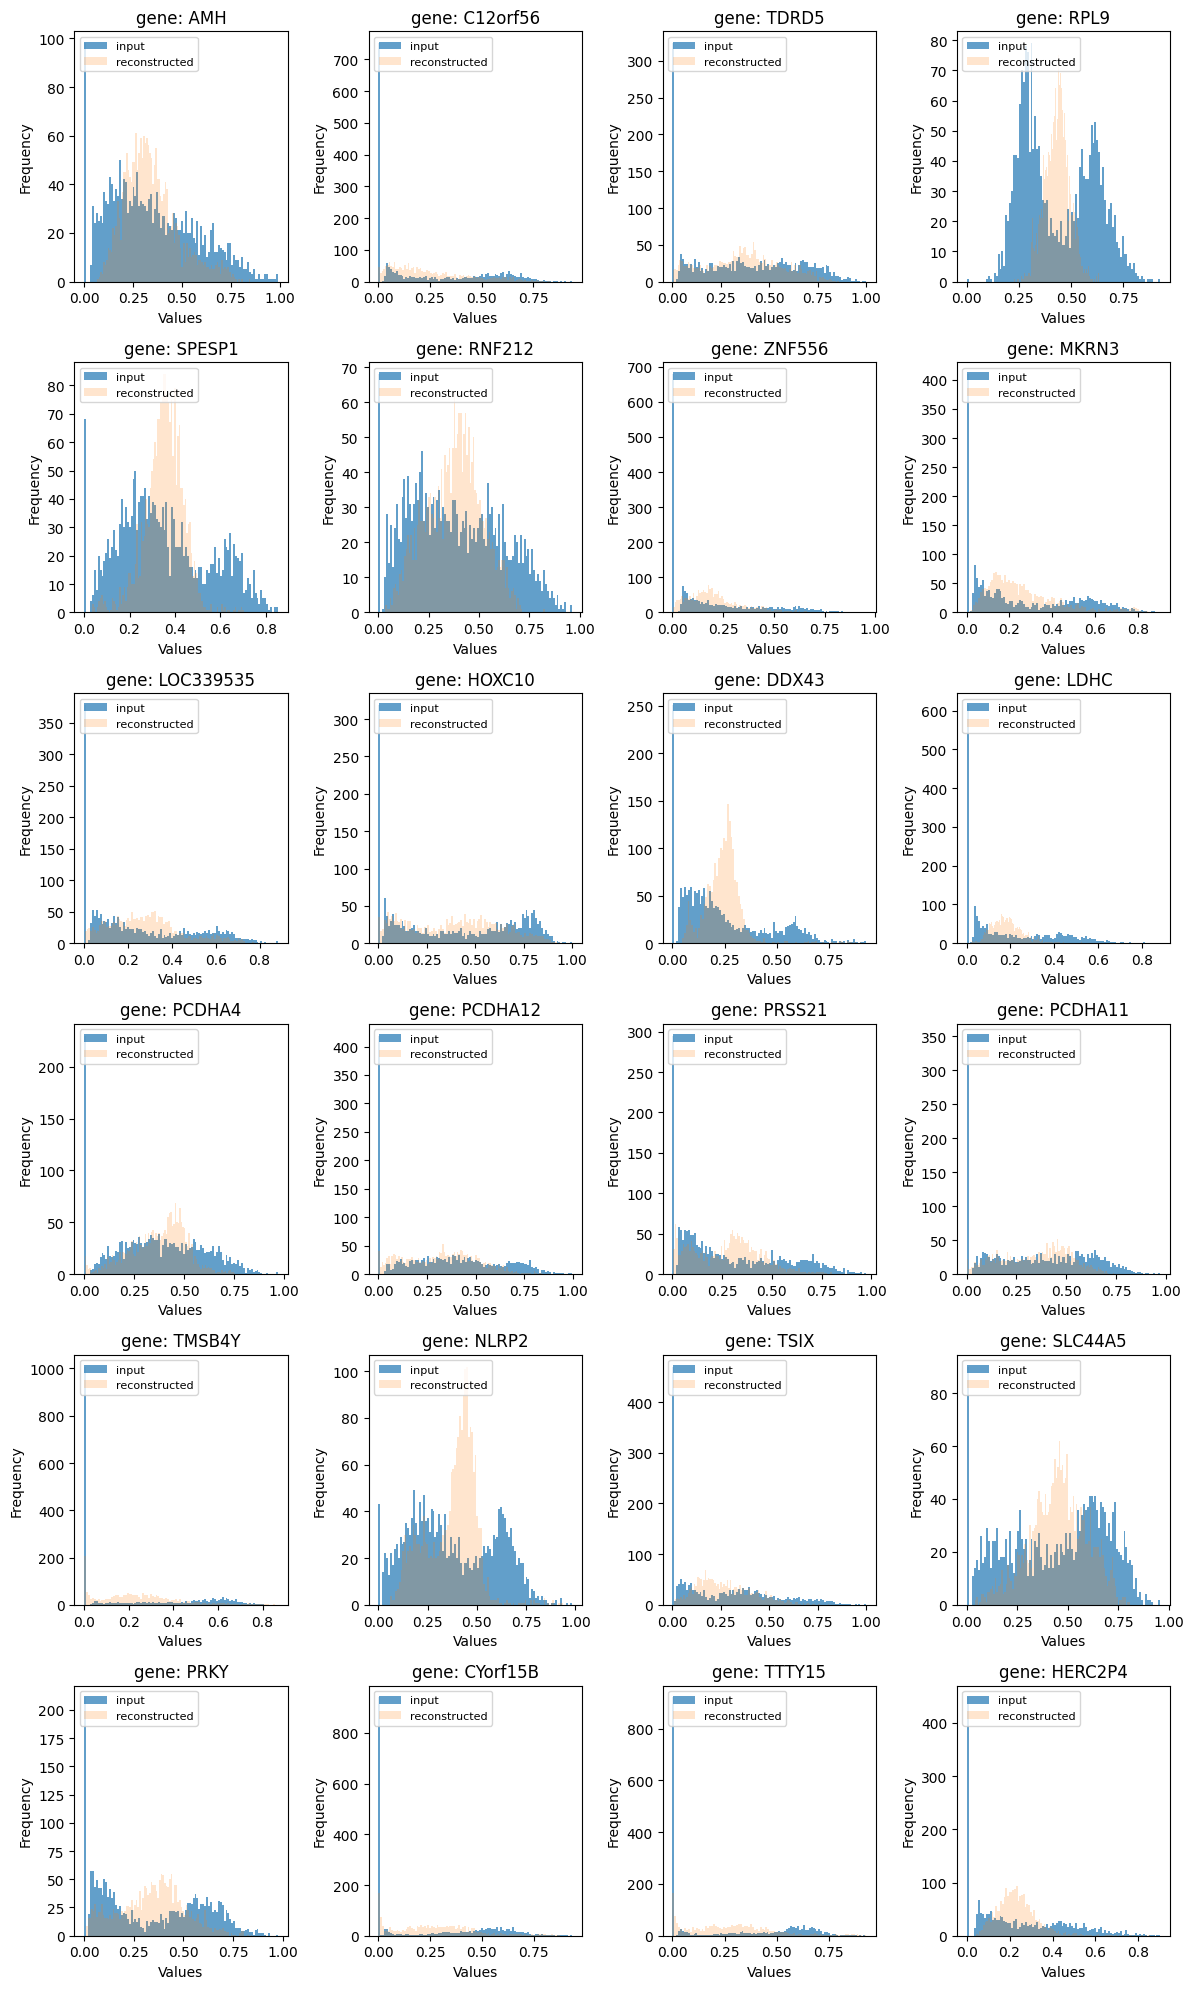

In [378]:
# results where reconstruction does not look good
plot_histograms_worst_genes(rnaseq_df, model)

#### Add noise and look at how reconstruction chnages 

In [299]:
# Define function to add gussian noise with different variance to each element of a pandas dataframe
def add_gaussian_noise(df, variances):
    assert len(variances) == len(
        df.columns
    ), "Number of variances must match the number of columns in the DataFrame."

    # Create a DataFrame with the same shape as the input DataFrame, filled with Gaussian random noise
    noise = pd.DataFrame(
        np.random.normal(0, np.sqrt(variances), size=df.shape), columns=df.columns
    )

    # Add the noise to the input DataFrame
    noisy_df = df + noise

    return noisy_df


# generate variances vector with a given upper values of maximum variance
def variance_vec(max_var, df):
    variances = np.linspace(0, max_var, len(df.columns))
    np.random.shuffle(variances)
    return variances

In [300]:
dataset_names_max_var = {
    "tcga_rnaseq_df_0p" + str(int(i * 100)): round(i, 2)
    for i in np.linspace(0.01, 0.9, 6)
}

In [301]:
# create a dictionary containing datasets with variable noises
noisy_datasets = {}
for i in dataset_names_max_var.keys():
    variance = variance_vec(dataset_names_max_var[i], rnaseq_df)
    noisy_datasets[i] = add_gaussian_noise(rnaseq_df, variance)

In [302]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

In [379]:
# plot best and worst genes before and after adding noise
def plot_hist_orig_vs_noisy_best_genes(df, model, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            linewidth=1,
        )
        ax.hist(
            df_noisy[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "after adding noise"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/original_vs_noise_genes.png")
    # Show the plot
    plt.show()

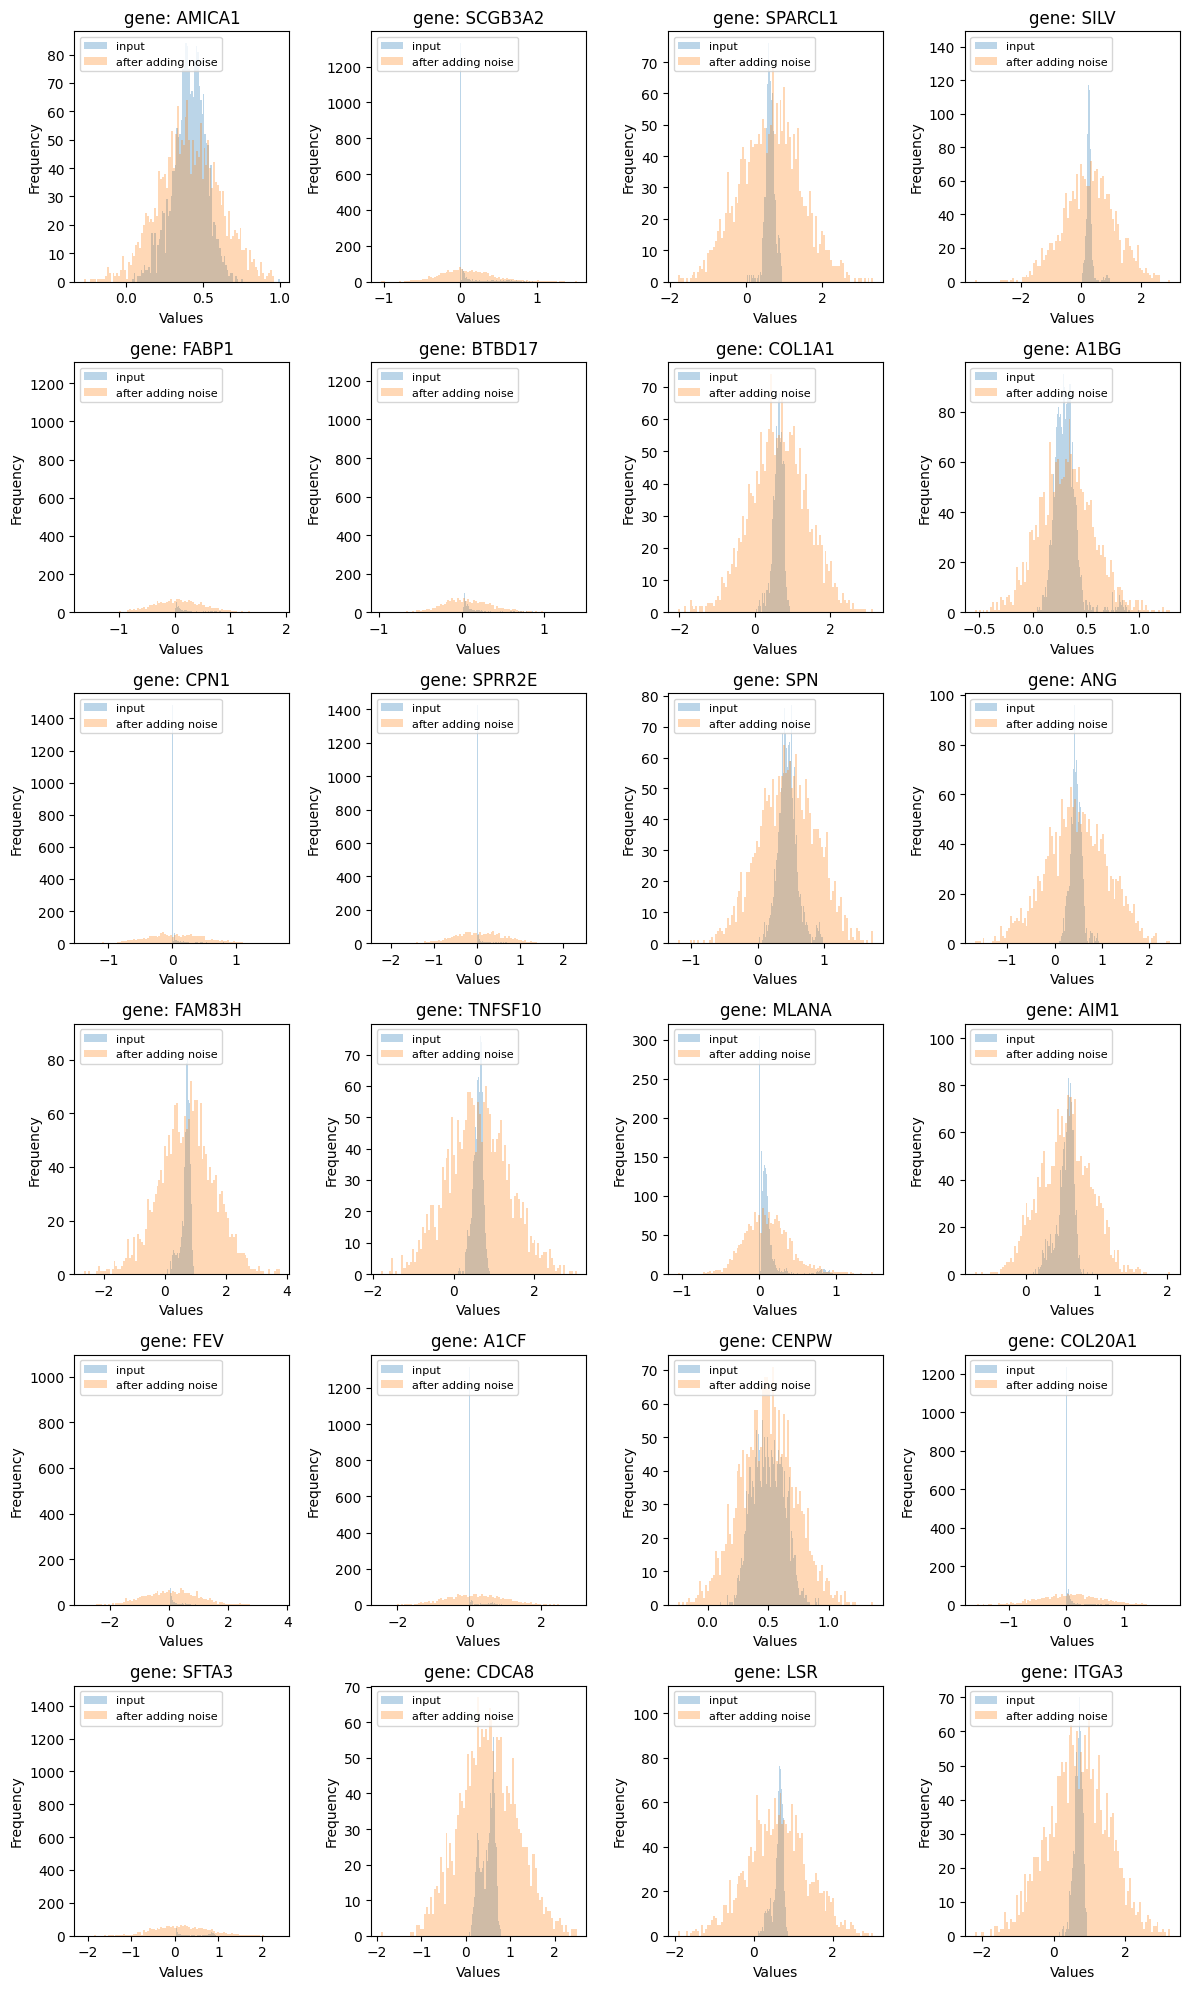

In [380]:
plot_hist_orig_vs_noisy_best_genes(rnaseq_df, model, df_noise)

In [381]:
# plot histograms for the genes which have best recontructions
def noise_recon_hist_best_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[60+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "reconst noise 0.9 GN"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/reconstructed_noise_added_best_genes.png")
    # Show the plot
    plt.show()

In [306]:
df_noise = noisy_datasets["tcga_rnaseq_df_0p90"]

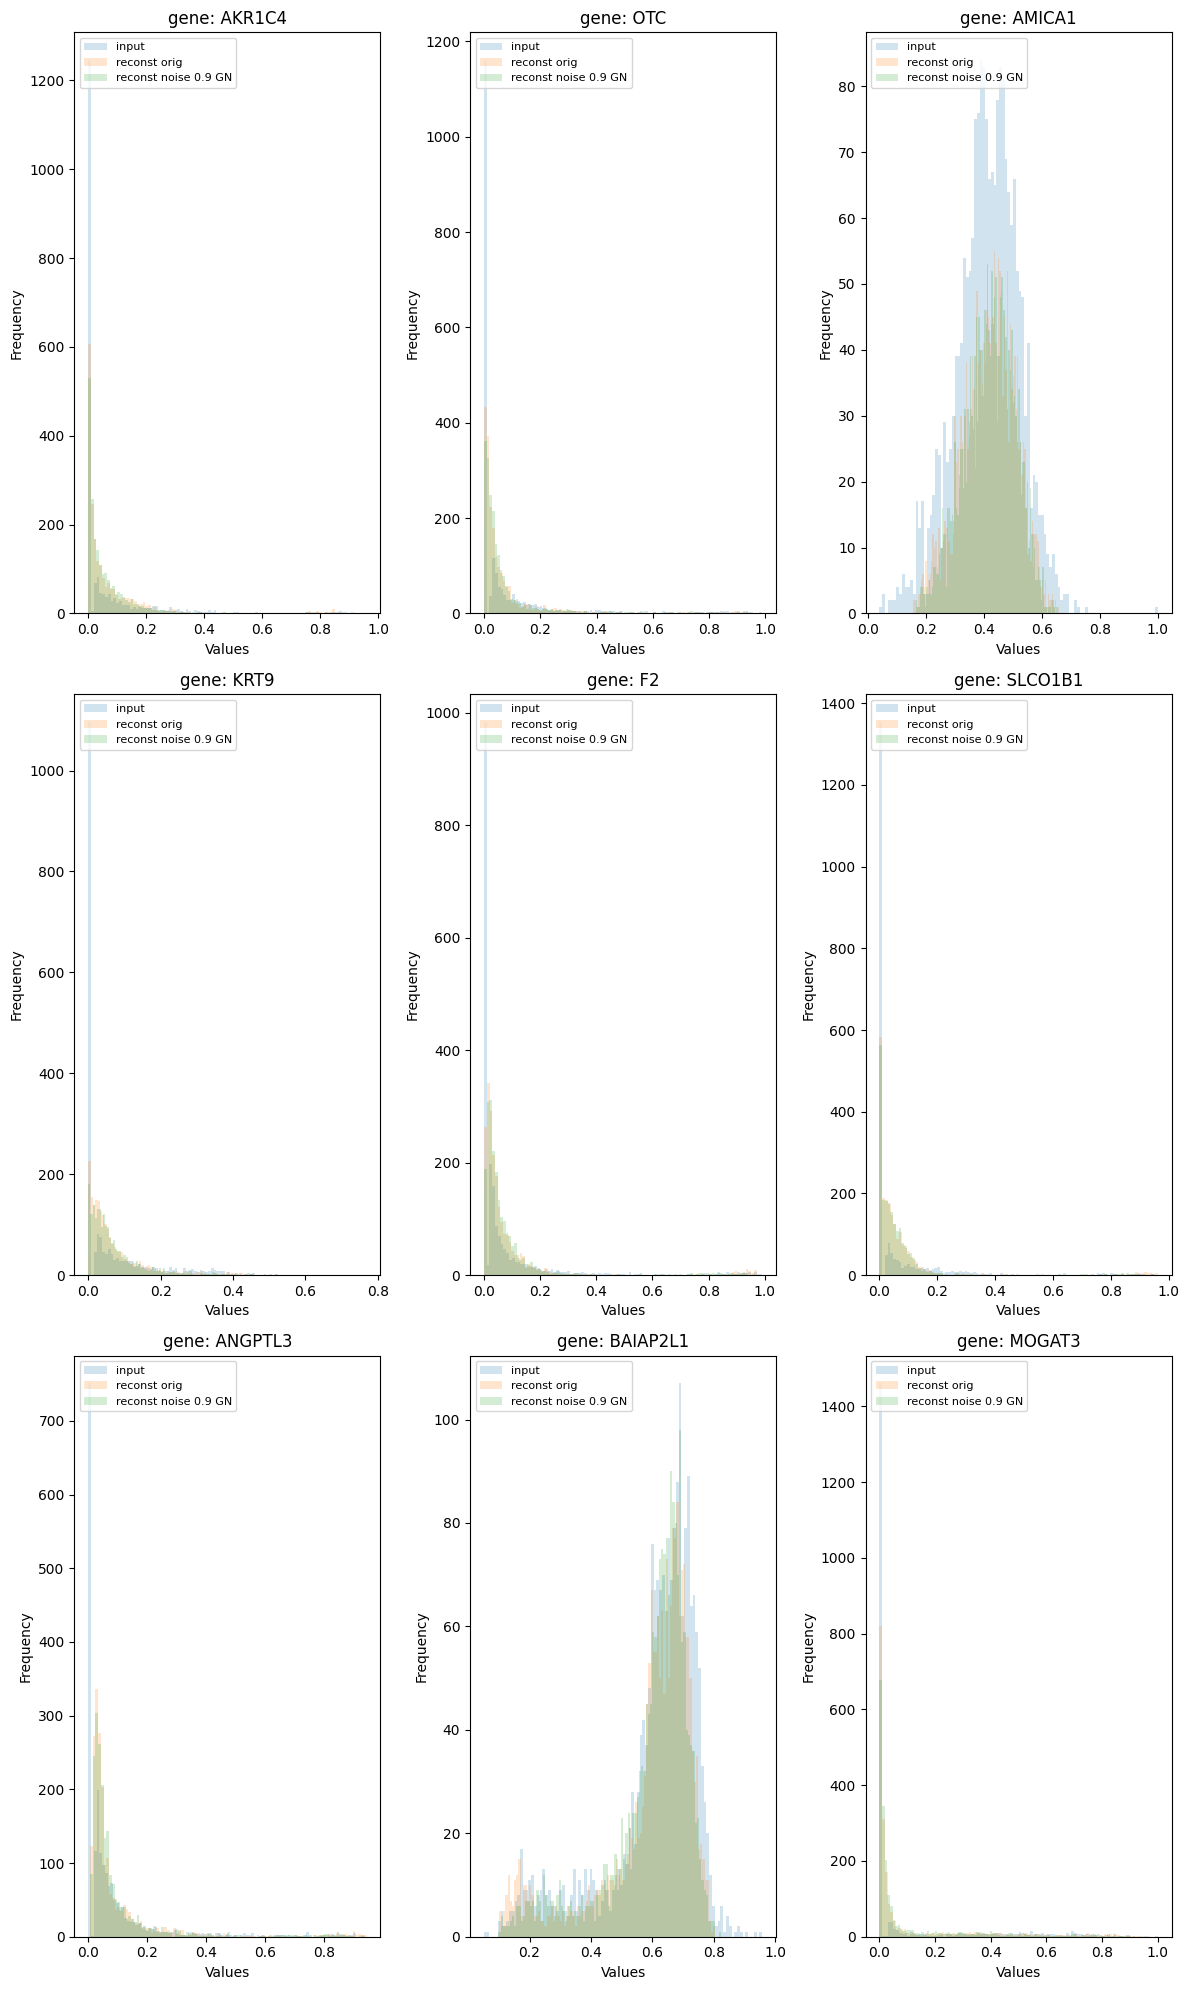

In [382]:
noise_recon_hist_best_genes(rnaseq_df, model, df_noise)

In [383]:
# plot histograms for the genes which have best recontructions
def noise_recon_hist_worst_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    worst_500_genes = list(gene_summary_sort.index[-500:])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[worst_500_genes[460 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(worst_500_genes[460+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "reconst noise 0.9 GN"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/reconstructed_noise_added_worst_genes.png")
    # Show the plot
    plt.show()

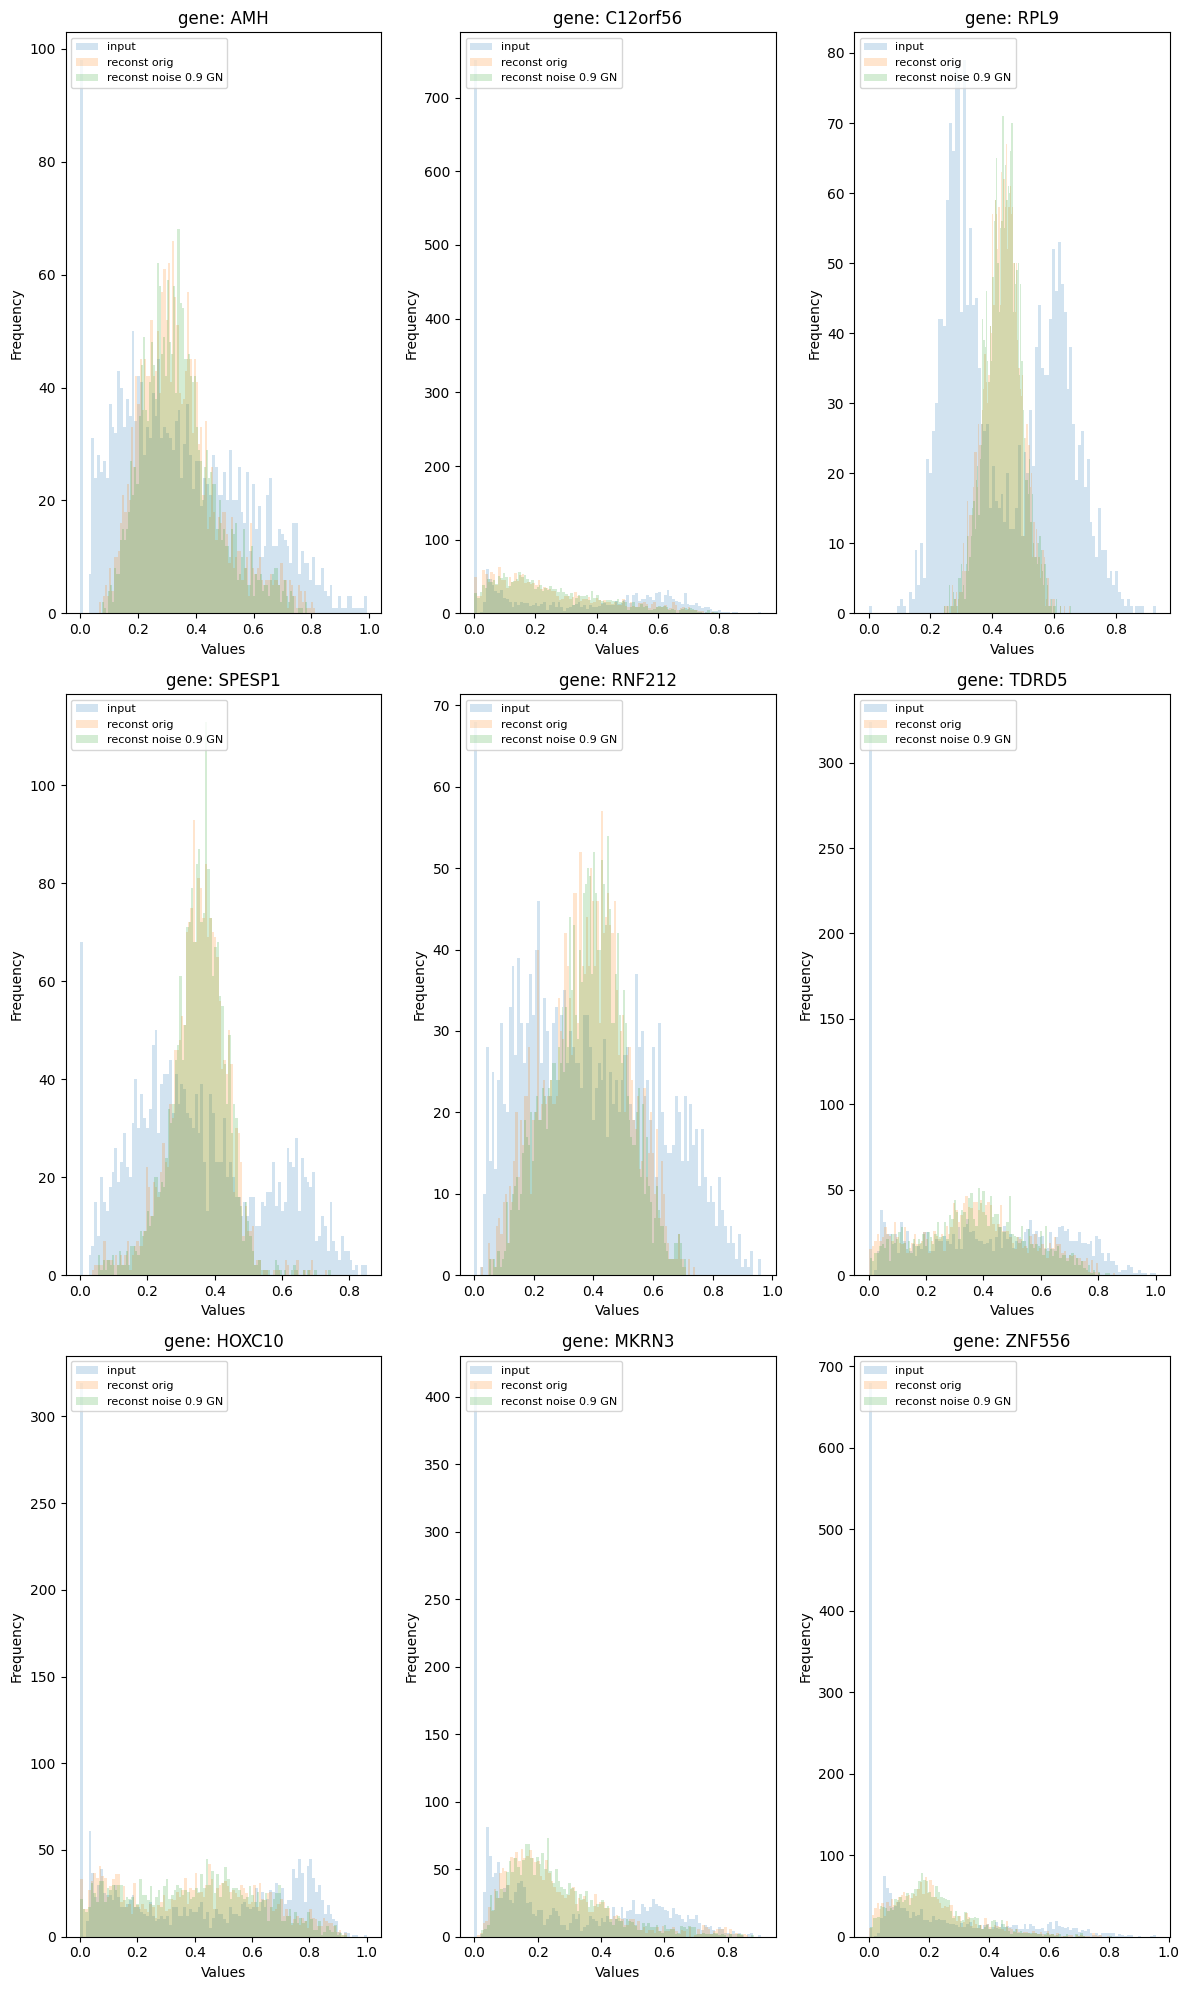

In [384]:
noise_recon_hist_worst_genes(rnaseq_df, model, df_noise)

### Look at the latent space after adding noise

In [310]:
noisy_datasets.keys()

dict_keys(['tcga_rnaseq_df_0p1', 'tcga_rnaseq_df_0p18', 'tcga_rnaseq_df_0p36', 'tcga_rnaseq_df_0p54', 'tcga_rnaseq_df_0p72', 'tcga_rnaseq_df_0p90'])

In [311]:
latent_mu, latent_sigma = VAE_latent_out(rnaseq_df)
latent_mu_noisy, latent_sigma_noisy = VAE_latent_out(
    noisy_datasets["tcga_rnaseq_df_0p90"]
)

In [312]:
# randomly select 15 columns in the latend space
random_column_num = [str(random.randint(0, 99)) for _ in range(24)]

In [313]:
latent_mu_sort = latent_mu[random_column_num]
latent_sigma_sort = latent_sigma[random_column_num]
latent_mu_sort_noisy = latent_mu_noisy[random_column_num]
latent_sigma_sort_noisy = latent_sigma_noisy[random_column_num]

In [387]:
# plot histograms for the letent space before and after adding noise
def plot_histograms_latent(df, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(df[df.columns[i]], bins=100, alpha=0.2, linewidth=1)
        ax.hist(
            df_noisy[df.columns[i]], bins=100, alpha=0.2, linewidth=1
        )
        ax.set_title(f"letent: {str(df.columns[i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["Original input", "Noisy input"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/letent_sigma_noise_added.png")
    # Show the plot
    plt.show()

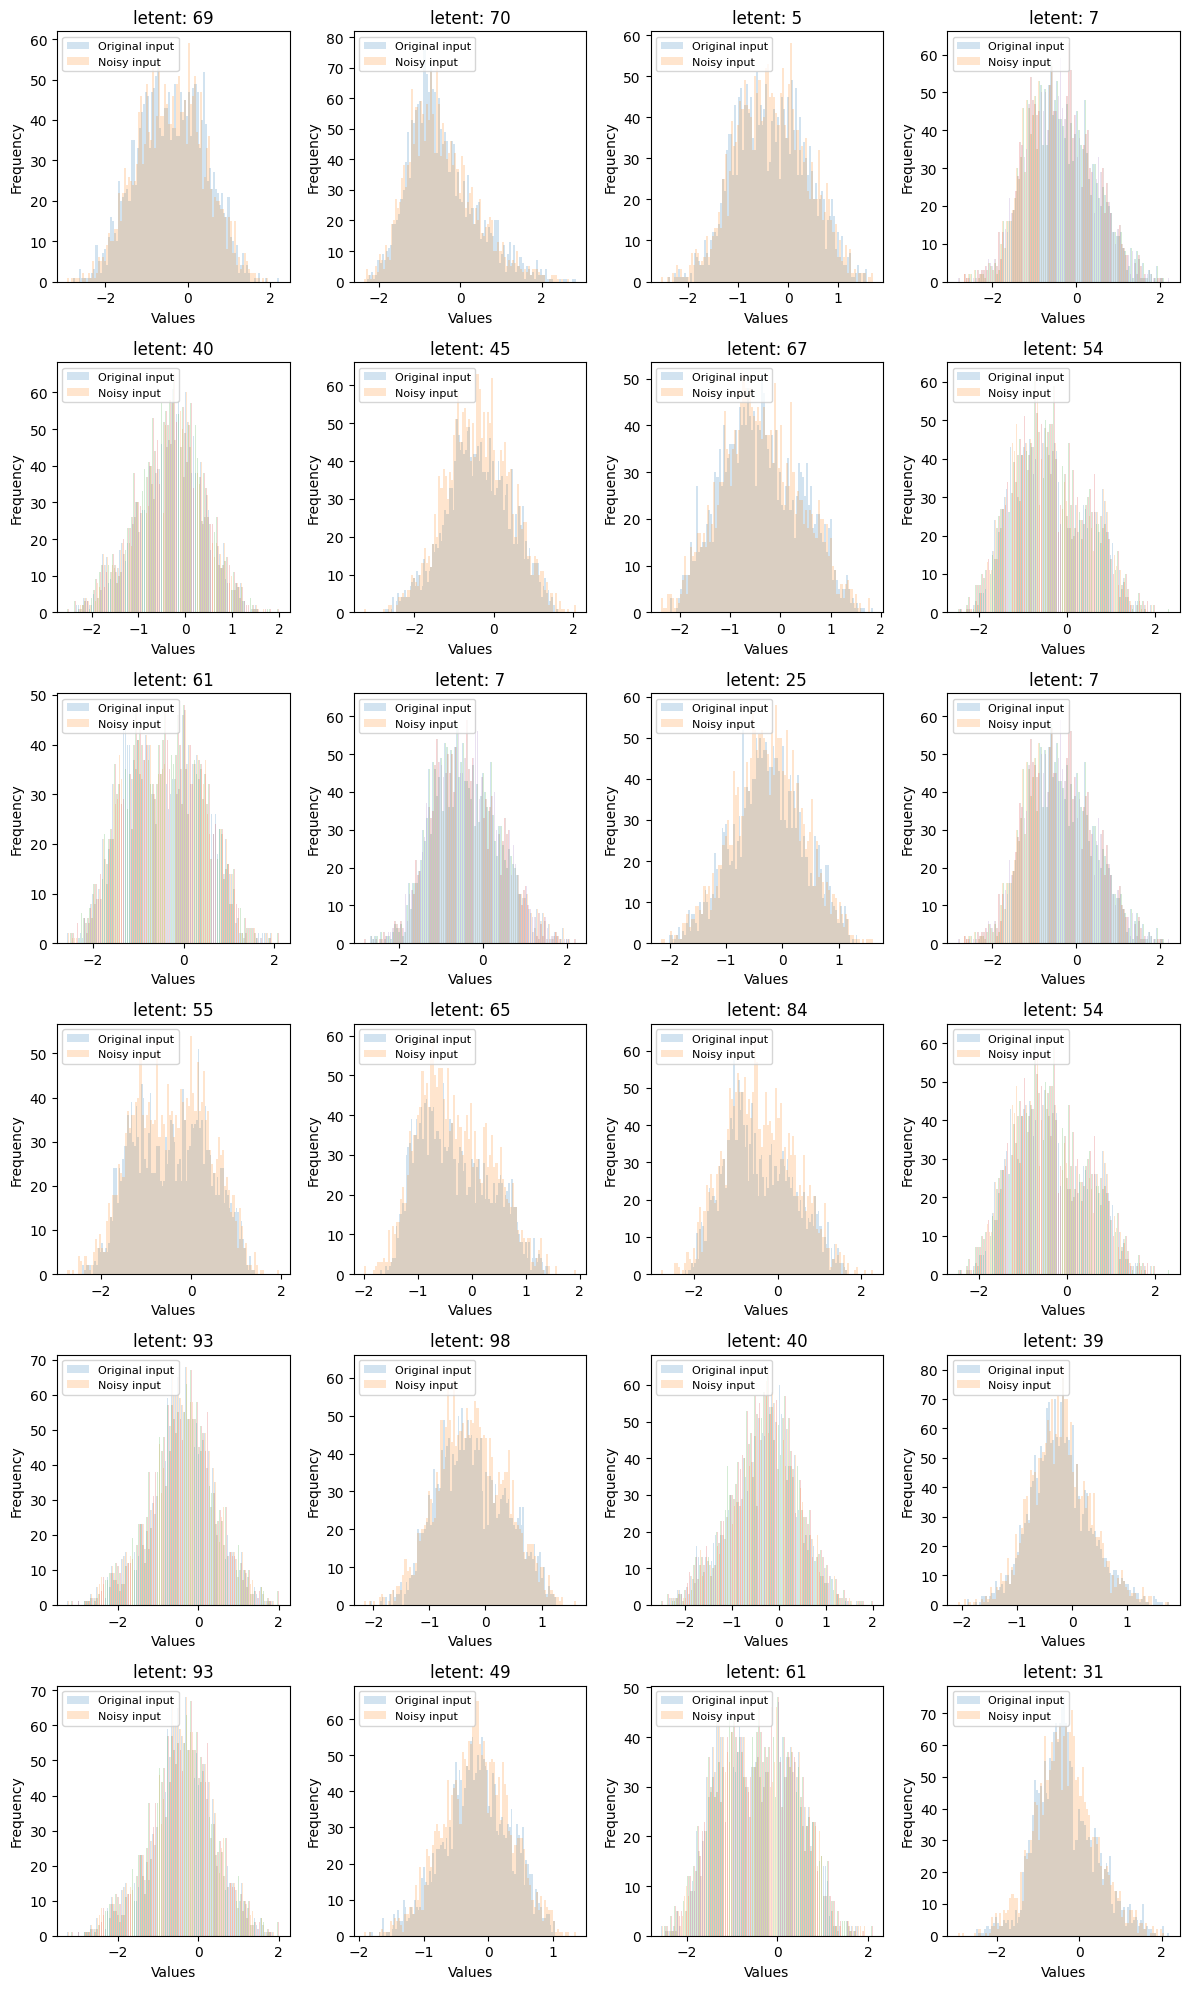

In [386]:
plot_histograms_latent(latent_mu_sort, latent_mu_sort_noisy)

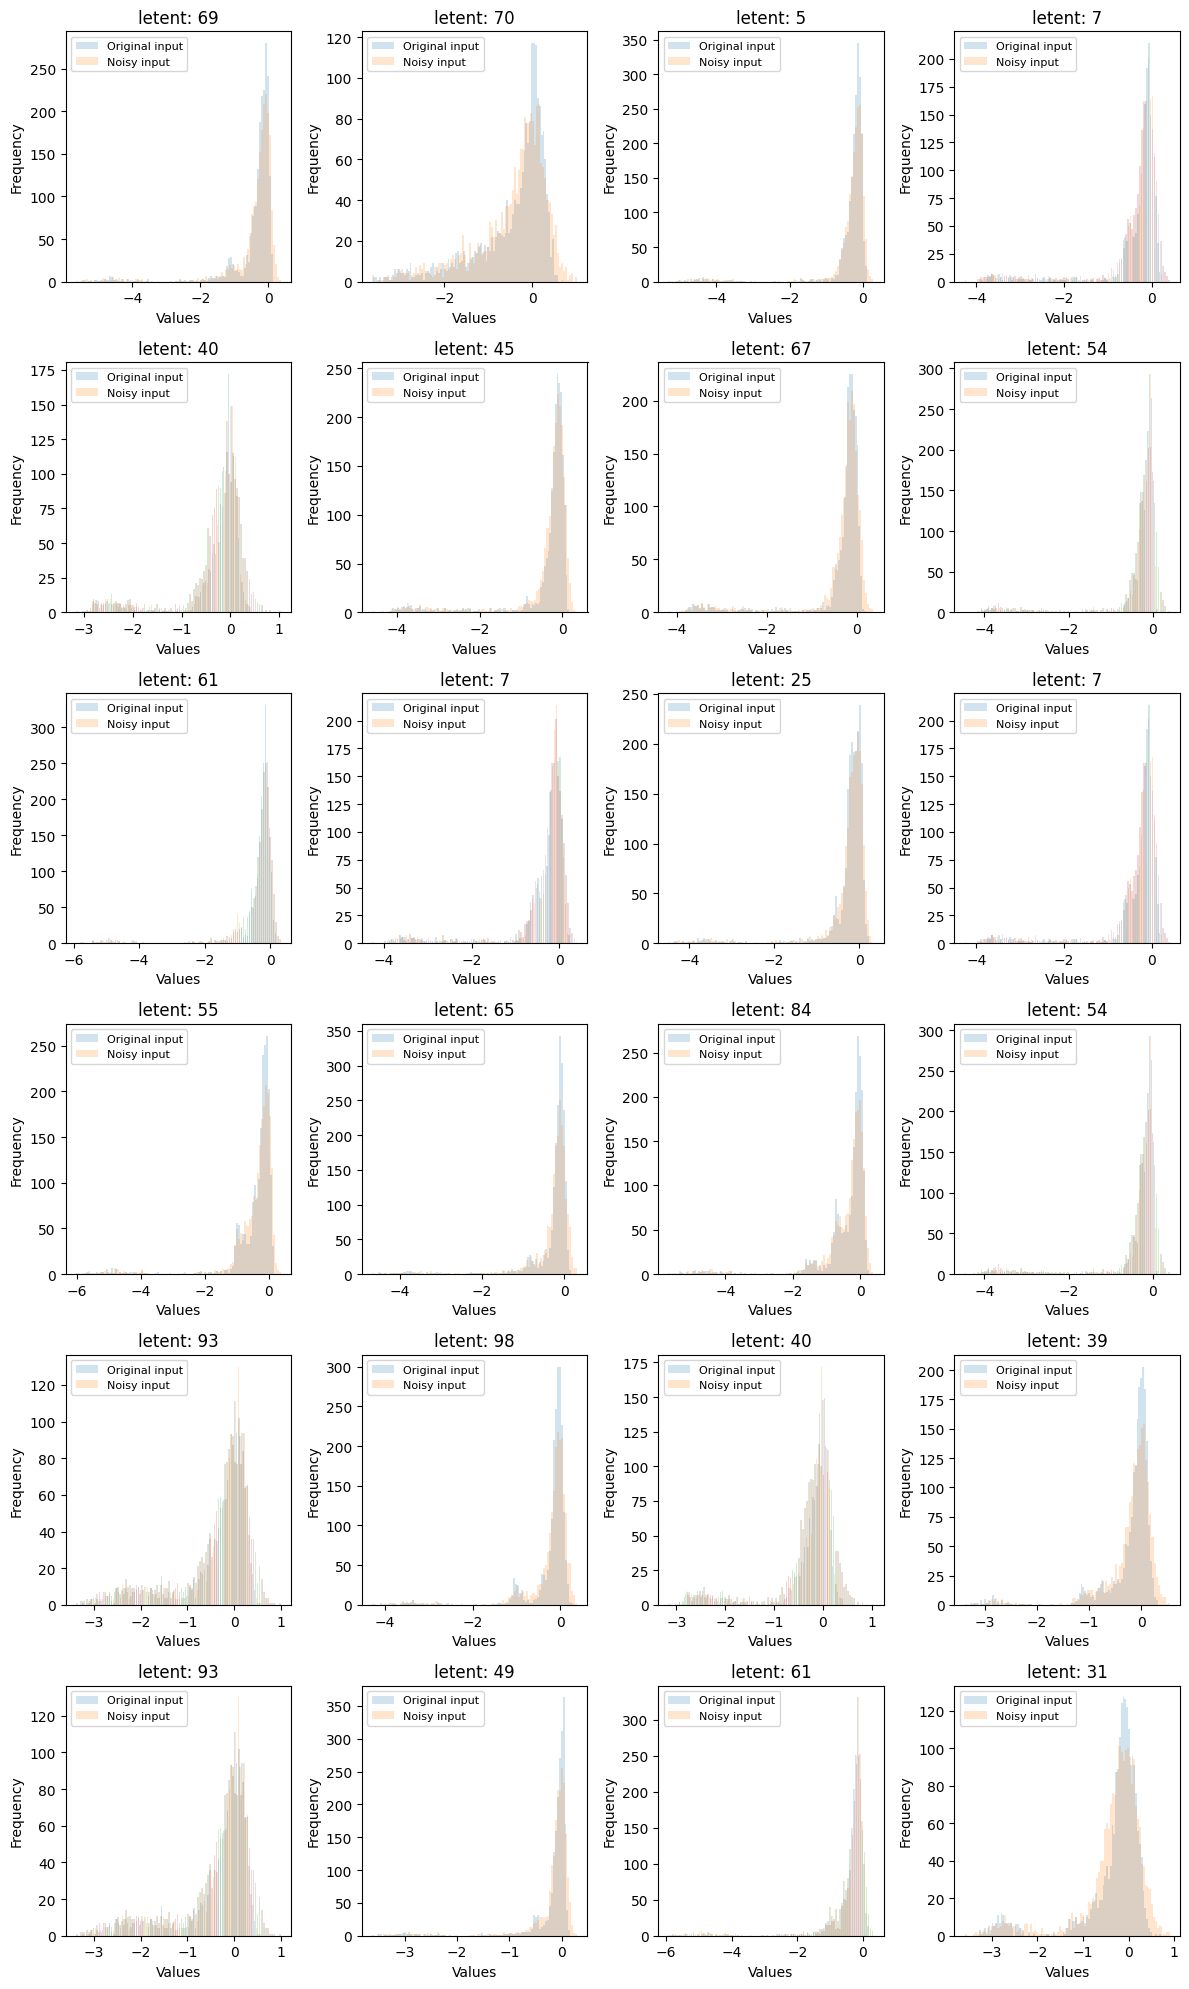

In [388]:
plot_histograms_latent(latent_sigma_sort, latent_sigma_sort_noisy)

#### Compute impact of adding noise to MSEs for genes with best reconstruction

In [322]:
# compute mse and bce between letent output and noisy latent output. Noisy here refers to latent data generated when input is noisy
def compute_latent_losses(df_true, df_pred):
    # Initialize an empty list to store the MSE values for each row
    mse_values = []

    # Loop through the rows of the DataFrames
    for index, row_true in df_true.iterrows():
        row_pred = df_pred.iloc[index]

        # Compute the MSE for the current row and append it to the mse_values list
        mse = mean_squared_error(row_true, row_pred)
        mse_values.append(mse)

    return mse_values

In [323]:
latent_mu, latent_var = VAE_latent_out(rnaseq_df)
means_mu = []
stds_mu = []
means_var = []
stds_var = []
for filename in noisy_datasets.keys():
    latent_mu_noisy, latent_var_noisy = VAE_latent_out(noisy_datasets[filename])

    latent_loss_mu = compute_latent_losses(latent_mu, latent_mu_noisy)
    latent_loss_var = compute_latent_losses(latent_var, latent_var_noisy)

    mean_mu = np.mean(latent_loss_mu)
    mean_var = np.mean(latent_loss_var)

    std_mu = np.std(latent_loss_mu)
    std_var = np.std(latent_loss_var)

    means_mu.append(mean_mu)
    means_var.append(mean_var)
    stds_mu.append(std_mu)
    stds_var.append(std_var)

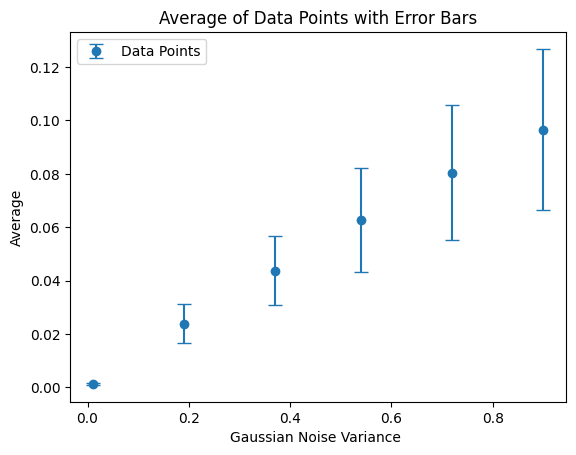

In [389]:
import matplotlib.pyplot as plt

x_values = [dataset_names_max_var[i] for i in dataset_names_max_var.keys()]
# Plot the average values with error bars
plt.errorbar(x_values, means_mu, yerr=stds_mu, fmt="o", capsize=5, label="Data Points")

# Add labels and a title
plt.xlabel("Gaussian Noise Variance ")
plt.ylabel("Average")
plt.title("Average of Data Points with Error Bars")

# Display a legend
plt.legend()
plt.savefig("../output/figures/MSE_GN_ampl.png")
# Show the plot
plt.show()

#### Check how permutation impact the above results

Let's see how results look with random permutation for earch row

In [353]:
# Each row is shuffled randomly
def shuffle_random_subset_rows(df, subset_size):
    """
    Shuffles a random subset of each row of a Pandas DataFrame while keeping column names.
    """
    df_shuffled = df.copy()
    num_cols = len(df.columns)
    for i in range(len(df_shuffled)):
        subset_cols = np.random.choice(num_cols, subset_size, replace=False)
        df_shuffled.iloc[i, subset_cols] = np.random.permutation(
            df_shuffled.iloc[i, subset_cols]
        )
    return df_shuffled


def generate_n_integers_uniform(n):
    random_integers = np.random.uniform(low=0, high=101, size=n).astype(int)
    return sorted(random_integers)

In [354]:
percent_shuffled = generate_n_integers_uniform(n=20)

In [355]:
shuffled_dataset = {
    "rnaseq_df_suffled_"
    + str(i): shuffle_random_subset_rows(rnaseq_df, int(rnaseq_df.shape[1] * i / 100))
    for i in percent_shuffled
}

In [356]:
shuffled_dataset.keys()

dict_keys(['rnaseq_df_suffled_9', 'rnaseq_df_suffled_10', 'rnaseq_df_suffled_17', 'rnaseq_df_suffled_20', 'rnaseq_df_suffled_25', 'rnaseq_df_suffled_26', 'rnaseq_df_suffled_34', 'rnaseq_df_suffled_35', 'rnaseq_df_suffled_36', 'rnaseq_df_suffled_49', 'rnaseq_df_suffled_50', 'rnaseq_df_suffled_54', 'rnaseq_df_suffled_61', 'rnaseq_df_suffled_75', 'rnaseq_df_suffled_78', 'rnaseq_df_suffled_83', 'rnaseq_df_suffled_91', 'rnaseq_df_suffled_99', 'rnaseq_df_suffled_100'])

In [390]:
# plot best and worst genes before and after adding noise
def plot_hist_orig_vs_noisy_best_genes_shuffle(df, model, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    df_reconstruct = VAE_reconstruct_df(df, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            linewidth=1,
        )
        ax.hist(
            df_noisy[best_500_genes[70 + i]],
            bins=100,
            alpha=0.3,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[70+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["input", "after adding noise"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/original_vs_noise_genes_shuffled.png")
    # Show the plot
    plt.show()

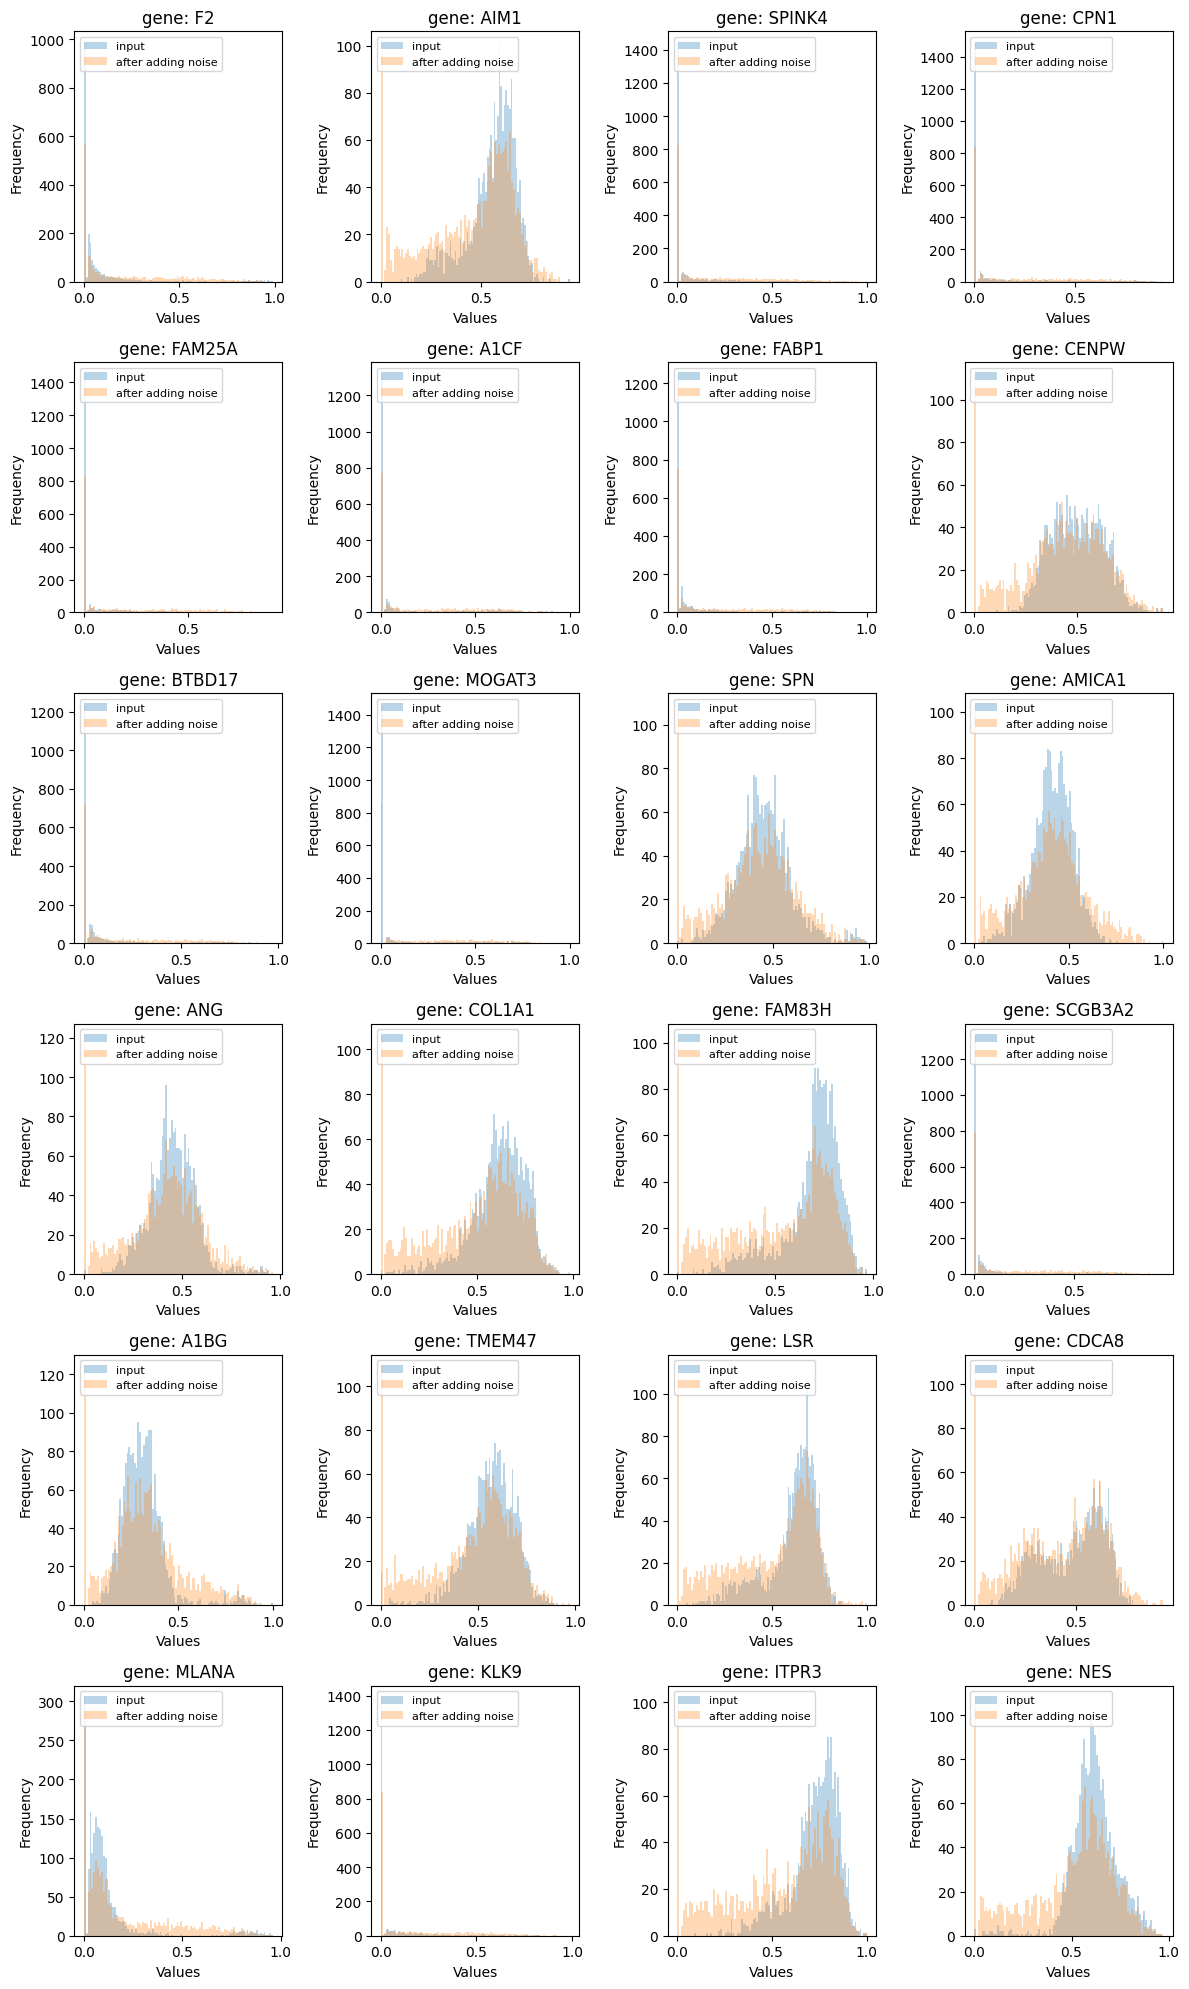

In [391]:
plot_hist_orig_vs_noisy_best_genes_shuffle(
    rnaseq_df, model, shuffled_dataset["rnaseq_df_suffled_49"]
)

In [392]:
# plot histograms for the genes which have best recontructions
def shuffled_recon_hist_best_genes(df, model, df_noise):
    # Define the number of rows and columns in the subplot grid
    num_rows = 3
    num_cols = 3

    df_reconstruct = VAE_reconstruct_df(df, model)
    df_reconstruct_noisy = VAE_reconstruct_df(df_noise, model)
    gene_summary_sort = gene_summary(df, df_reconstruct)
    best_500_genes = list(gene_summary_sort.index[:500])
    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(
            df[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.hist(
            df_reconstruct_noisy[best_500_genes[60 + i]],
            bins=100,
            alpha=0.2,
            linewidth=1,
        )
        ax.set_title(f"gene: {str(best_500_genes[60+i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(
            ["input", "reconst orig", "shuffled"],
            fontsize="8",
            loc="upper left",
        )

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/Reconstructed_shuffled_gene.png")
    # Show the plot
    plt.show()

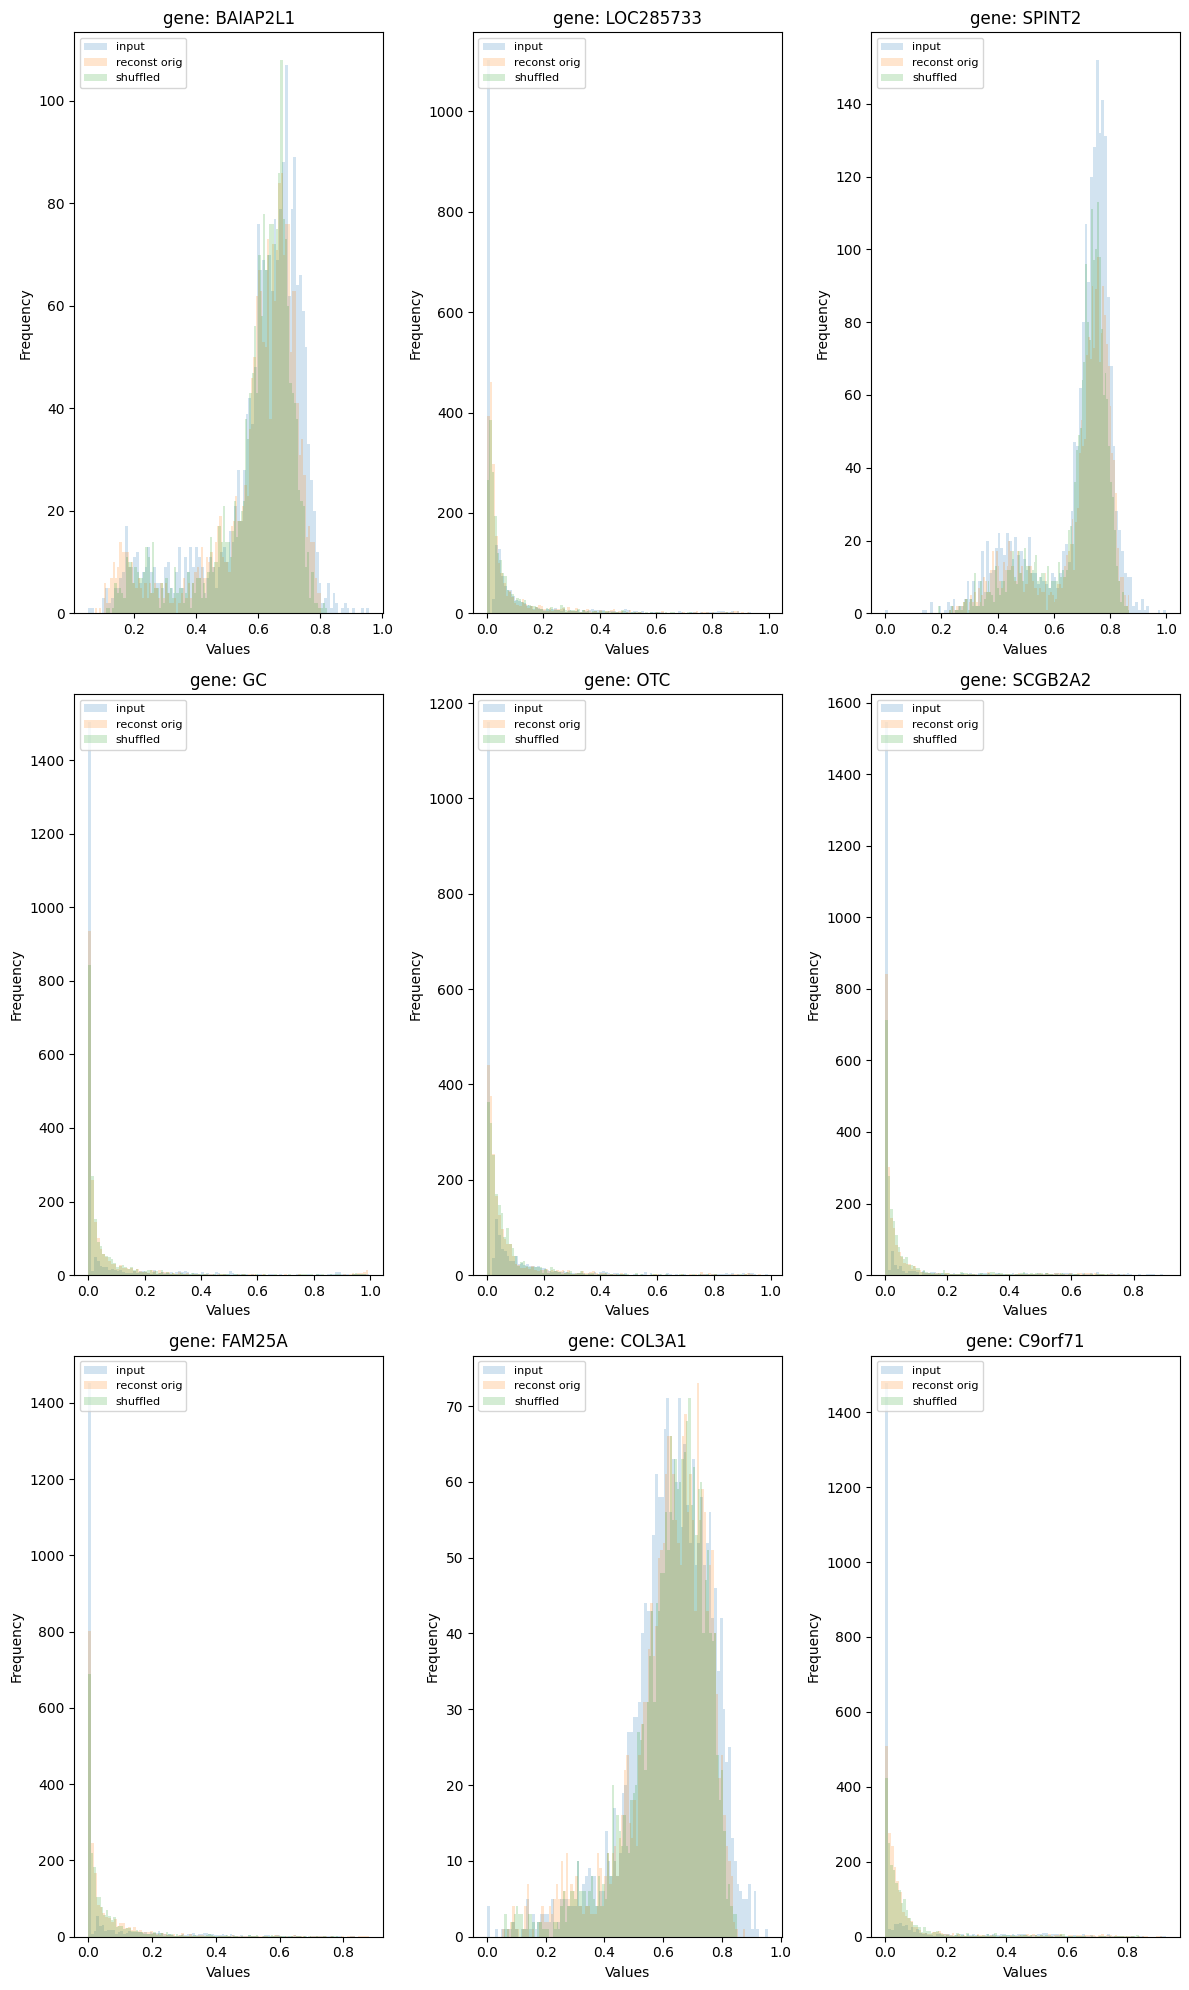

In [393]:
shuffled_recon_hist_best_genes(
    rnaseq_df, model, shuffled_dataset["rnaseq_df_suffled_49"]
)

Look at the latent space

In [360]:
latent_mu_shuffled, latent_sigma_shuffled = VAE_latent_out(
    shuffled_dataset["rnaseq_df_suffled_49"]
)

In [361]:
latent_mu_shuffled_sort = latent_mu_shuffled[random_column_num]
latent_sigma_shuffled_sort = latent_sigma_shuffled[random_column_num]

In [394]:
# plot histograms for the letent space before and after adding noise
def plot_histograms_latent(df, df_noisy):
    # Define the number of rows and columns in the subplot grid
    num_rows = 6
    num_cols = 4

    # Create a figure
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 20))

    # Plot the histograms
    for i, ax in enumerate(axes.flatten()):
        ax.hist(df[df.columns[i]], bins=100, alpha=0.2, linewidth=1)
        ax.hist(
            df_noisy[df.columns[i]], bins=100, alpha=0.2, linewidth=1
        )
        ax.set_title(f"letent: {str(df.columns[i])}")
        ax.set_xlabel("Values")
        ax.set_ylabel("Frequency")
        ax.legend(["Original input", "Noisy input"], fontsize="8", loc="upper left")

    # Adjust the layout to prevent overlapping
    plt.tight_layout()
    plt.savefig("../output/figures/letent_sigma_shuffled.png")
    # Show the plot
    plt.show()

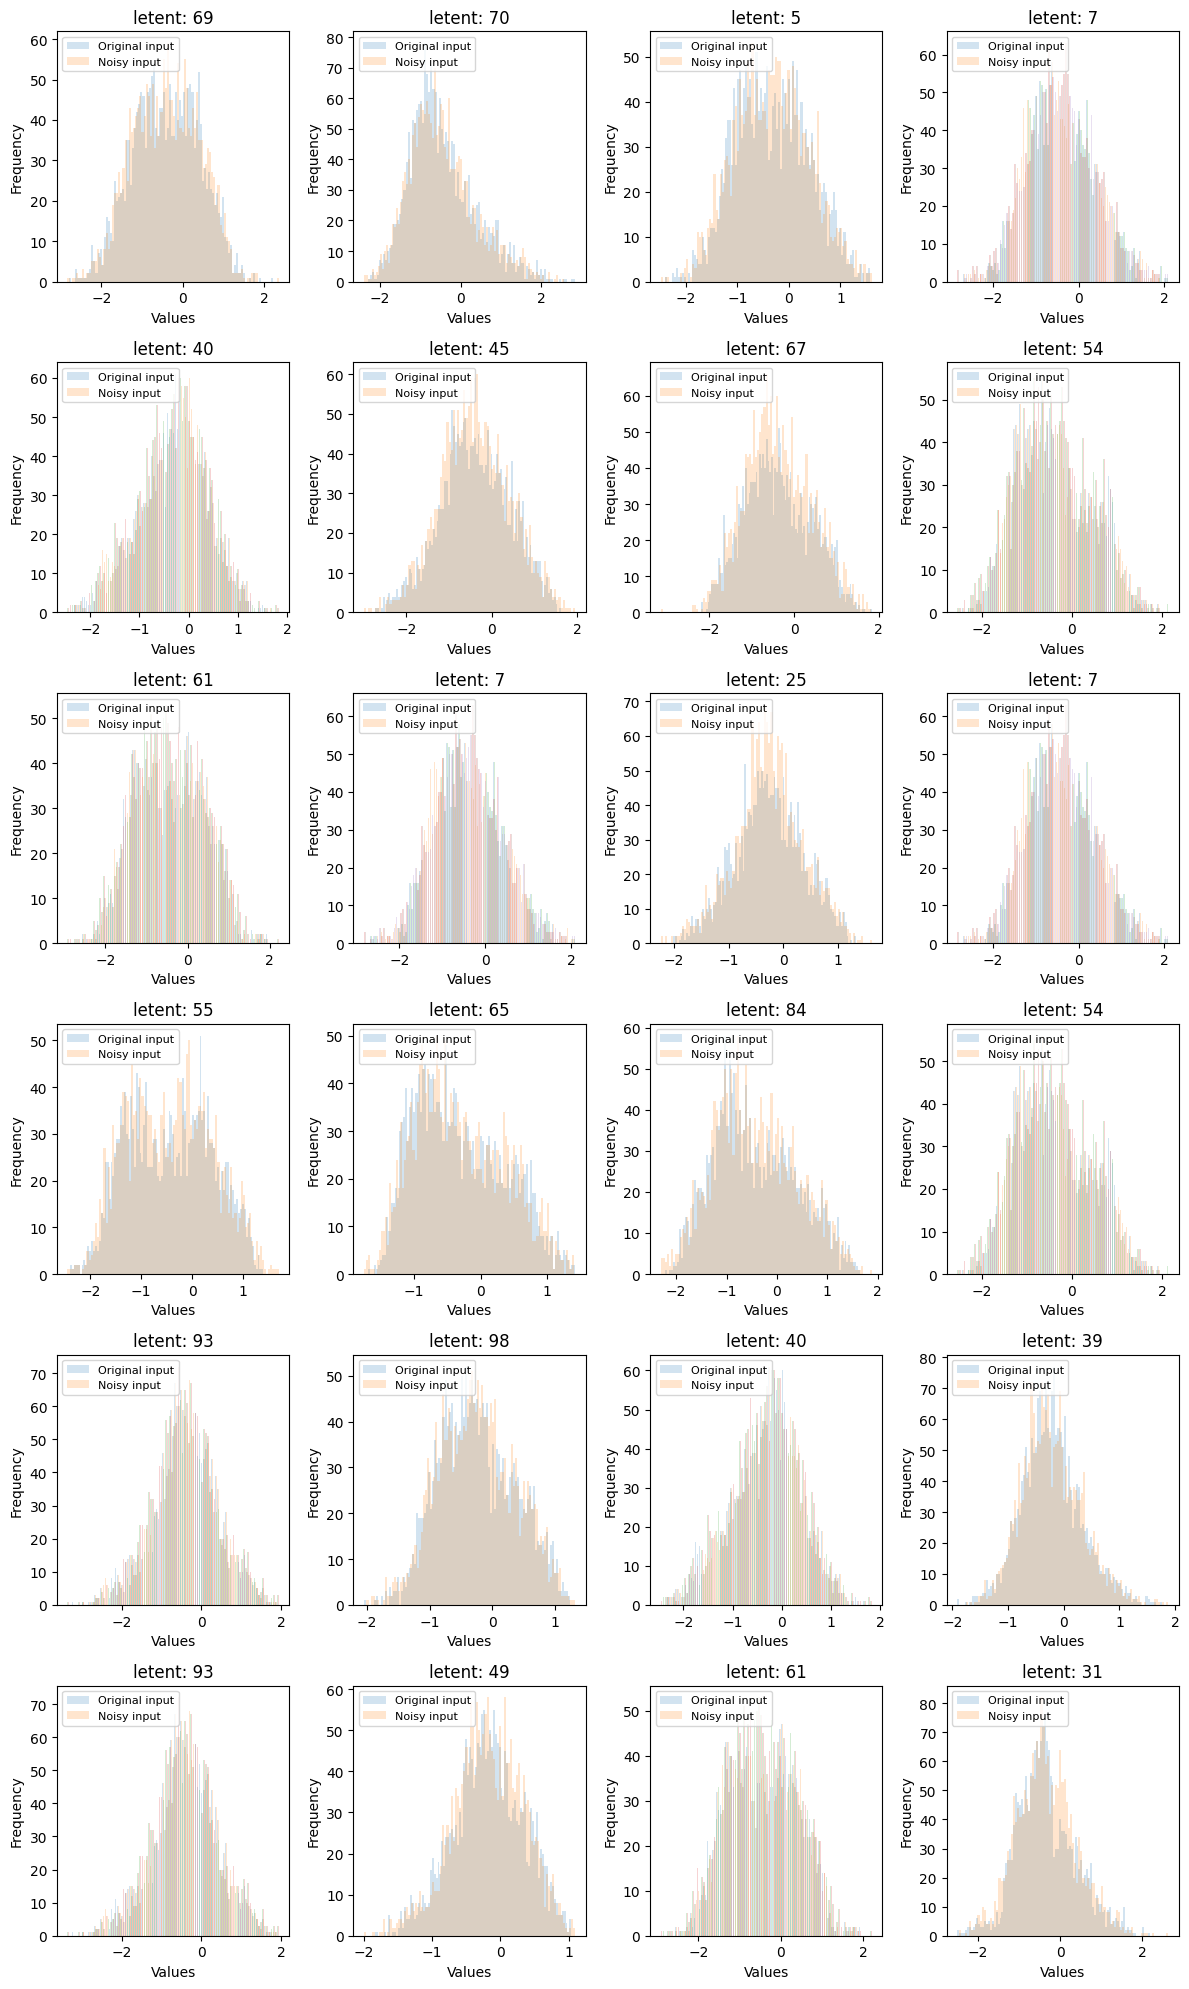

In [395]:
plot_histograms_latent(latent_mu_sort, latent_mu_shuffled_sort)

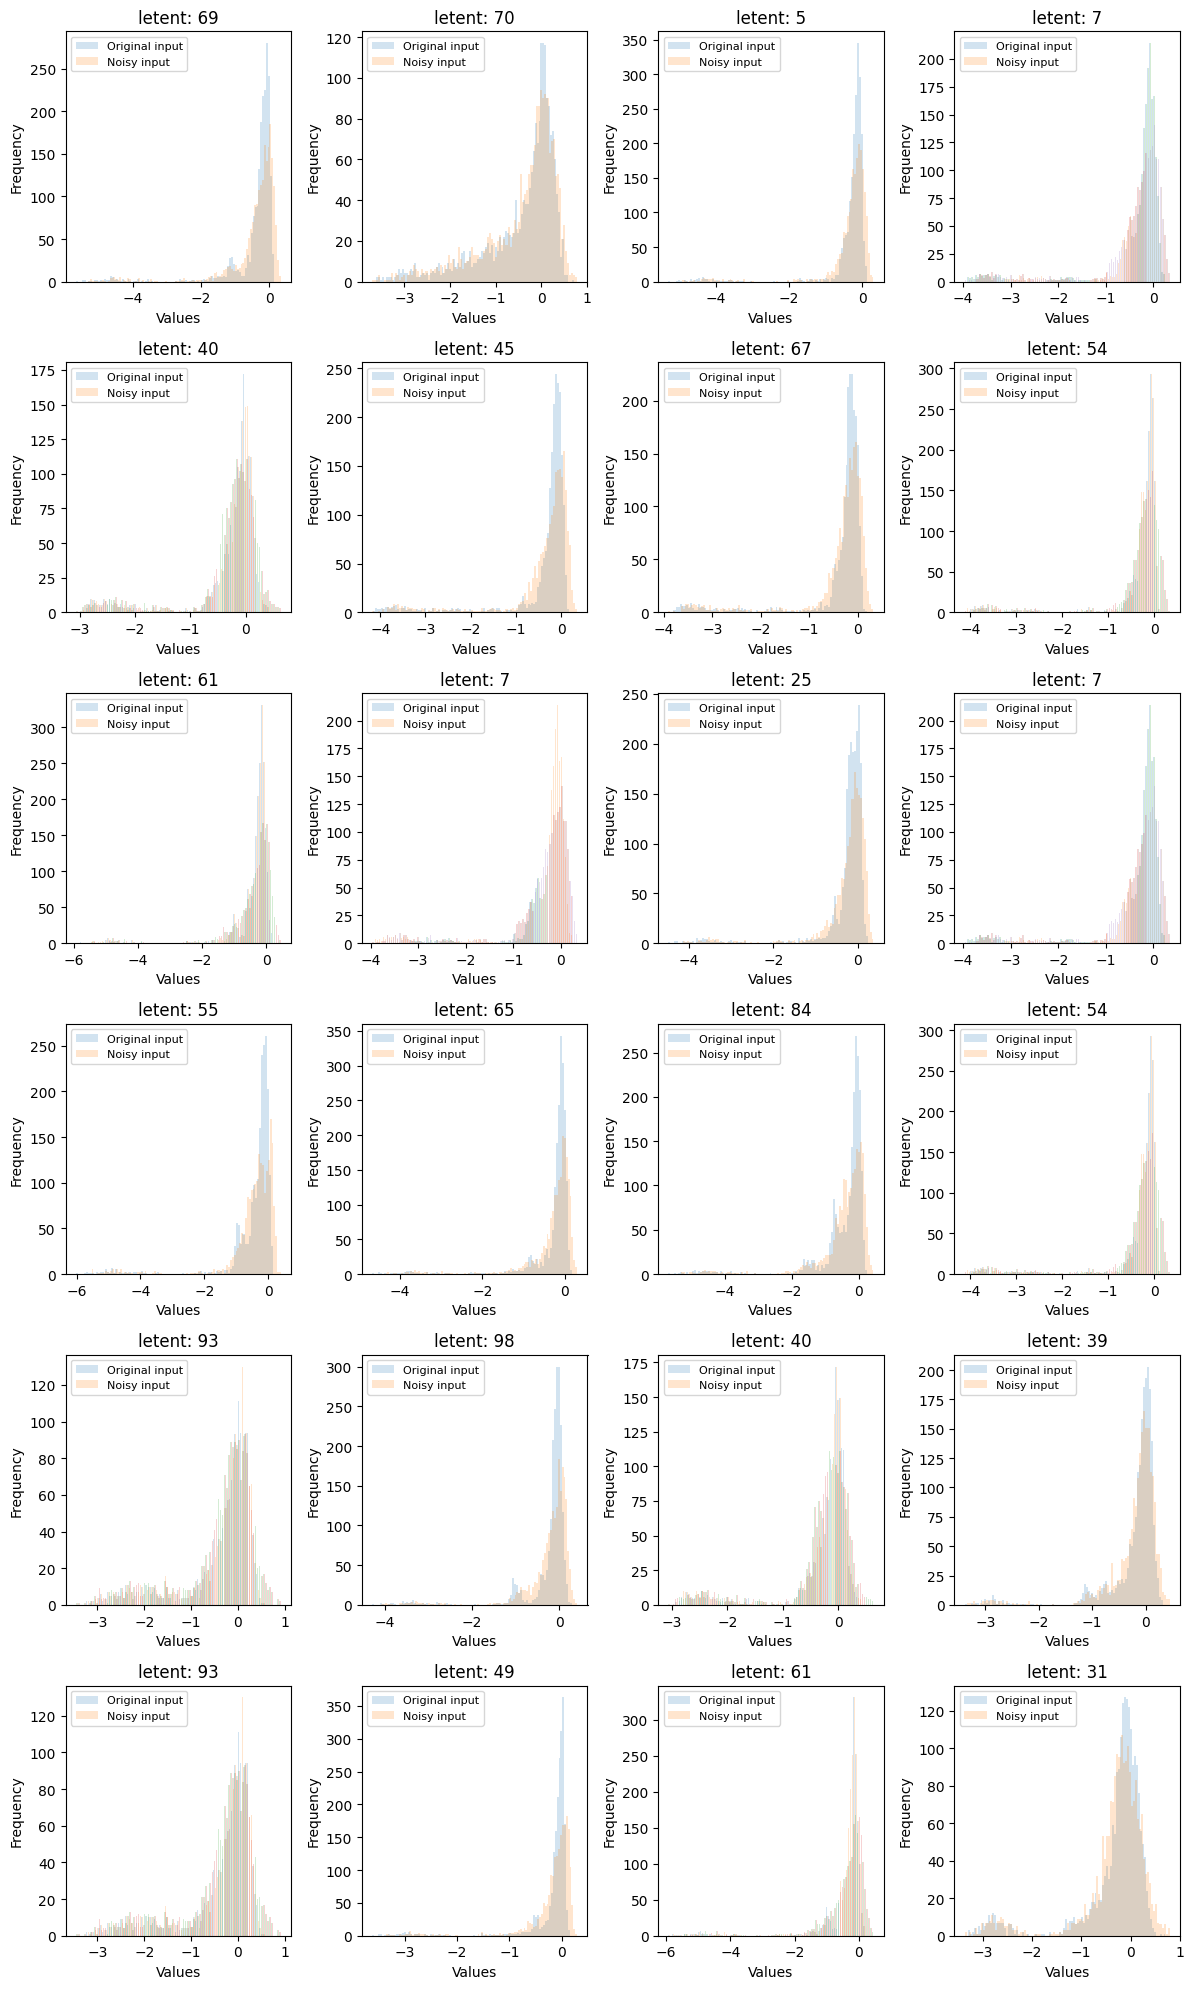

In [396]:
plot_histograms_latent(latent_sigma_sort, latent_sigma_shuffled_sort)

In [363]:
means_mu_shuffled = []
stds_mu_shuffled = []
means_var_shuffled = []
stds_var_shuffled = []
for filename in shuffled_dataset.keys():
    latent_mu_noisy, latent_var_noisy = VAE_latent_out(shuffled_dataset[filename])

    latent_loss_mu = compute_latent_losses(latent_mu, latent_mu_noisy)
    latent_loss_var = compute_latent_losses(latent_var, latent_var_noisy)

    mean_mu = np.mean(latent_loss_mu)
    mean_var = np.mean(latent_loss_var)

    std_mu = np.std(latent_loss_mu)
    std_var = np.std(latent_loss_var)

    means_mu_shuffled.append(mean_mu)
    means_var_shuffled.append(mean_var)
    stds_mu_shuffled.append(std_mu)
    stds_var_shuffled.append(std_var)

In [370]:
percent_shuffled

[9,
 10,
 17,
 20,
 25,
 26,
 34,
 35,
 36,
 49,
 50,
 54,
 61,
 75,
 78,
 83,
 91,
 99,
 99,
 100]

In [369]:
print(len(percent_shuffled))
print(len(means_mu_shuffled))

20
19


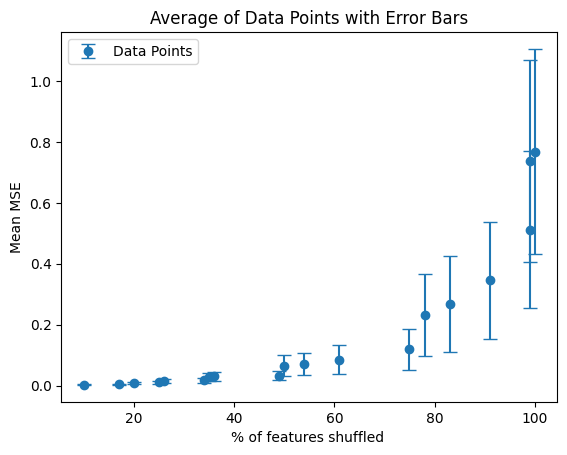

In [397]:
x_values = percent_shuffled[1:]
# Plot the average values with error bars
plt.errorbar(
    x_values,
    means_mu_shuffled,
    yerr=stds_mu_shuffled,
    fmt="o",
    capsize=5,
    label="Data Points",
)

# Add labels and a title
plt.xlabel("% of features shuffled ")
plt.ylabel("Mean MSE")
plt.title("Average of Data Points with Error Bars")

# Display a legend
plt.legend()
plt.savefig("../output/figures/MSE_shuffled.png")
# Show the plot
plt.show()

#### Look at downstream tasks

Load clinical data

In [183]:
clincal_file = "../../VAE_prject_data/raw/clinical_data.tsv"
clincal_df = pd.read_table(clincal_file)

In [185]:
gene_file = "../../VAE_prject_data/raw/pancan_scaled_zeroone_rnaseq.tsv.gz"
rnaseq_df_test = pd.read_table(gene_file, index_col=0)
print(rnaseq_df_test.shape)
rnaseq_df_test.head(2)
rnaseq_df_test = rnaseq_df_test.drop("TCGA-33-4579-01", axis=0)

(10459, 5000)


In [186]:
def find_matching_row_indices(df1, df2):
    # Concatenate the two DataFrames and reset their indices
    combined_df = pd.concat([df1, df2]).reset_index(drop=True)

    # Find the duplicated rows in the combined DataFrame and retrieve their indices
    duplicated_rows = combined_df.duplicated(keep=False)
    matching_indices = combined_df[duplicated_rows].index

    # Separate the indices for the two original DataFrames
    df1_indices = matching_indices[matching_indices < len(df1)]
    df2_indices = matching_indices[matching_indices >= len(df1)] - len(df1)

    return df1_indices, df2_indices


df1_matching_indices, df2_matching_indices = find_matching_row_indices(
    rnaseq_df, rnaseq_df_test
)

In [187]:
all_indices = list(rnaseq_df_test.index)

In [188]:
rnaseq_df_indexes = [all_indices[i] for i in df1_matching_indices]

In [189]:
len(rnaseq_df_indexes)

2092

In [190]:
def find_rows_with_substring(df, column_name, substring_list):
    # Find the rows where the specified column contains any of the substrings
    matching_rows = df[
        df[column_name].apply(
            lambda x: any(substring in x for substring in substring_list)
            if isinstance(x, str)
            else False
        )
    ]

    # Update the column values to the values in the substring list
    matching_rows[column_name] = matching_rows[column_name].apply(
        lambda x: next((substring for substring in substring_list if substring in x), x)
    )

    return matching_rows


column_name = "portion_id"
substring_list = rnaseq_df_indexes

result = find_rows_with_substring(clincal_df, column_name, substring_list)

/var/folders/pz/58p838cs59d_ph9d15d3ltgc0000gs/T/ipykernel_25888/3407430512.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matching_rows[column_name] = matching_rows[column_name].apply(lambda x: next((substring for substring in substring_list if substring in x), x))


In [201]:
def keep_first_duplicate(df, column_name):
    unique_rows_df = df.drop_duplicates(subset=column_name, keep="first")
    return unique_rows_df


rnaseq_unique_rows_df = keep_first_duplicate(result, column_name)

In [203]:
rnaseq_unique_rows_df.head(3)

,sample_id,ethnicity,year_of_diagnosis,gender,race,organ,percent_tumor_nuclei,age_at_diagnosis,sample_type,analysis_center,vital_status,acronym,portion_id,disease,drug,platform,stage
5,TCGA-2G-AAKD,not hispanic or latino,NaN,male,white,Testis,60.0,18.0,Primary Tumor,UNC,alive,TGCT,TCGA-2G-AAKD-01,Testicular Germ Cell Tumors,Cisplatin,Illumina HiSeq,Stage III
8,TCGA-A2-A0CL,not hispanic or latino,2006,female,black or african american,Breast,60.0,37.0,Primary Tumor,UNC,alive,BRCA,TCGA-A2-A0CL-01,Breast invasive carcinoma,Taxol,Illumina HiSeq,Stage IIIA
16,TCGA-A2-A0D2,not hispanic or latino,2008,female,white,Breast,80.0,45.0,Primary Tumor,UNC,alive,BRCA,TCGA-A2-A0D2-01,Breast invasive carcinoma,Adriamycin,Illumina HiSeq,Stage IIA


In [211]:
disease_labels = list(rnaseq_unique_rows_df["disease"])

In [213]:
len(set(disease_labels))

24

In [214]:
len(disease_labels)

2092

In [216]:
len(set(list(rnaseq_unique_rows_df["stage"])))

16

#### Apply PCA to latent and see how data look like for each label catagory

In [247]:
# How well does the model reconstruct the input RNAseq data
from sklearn.model_selection import train_test_split
def VAE_latent_out_resampled(df, model):
    z = model.forward(torch.tensor(df.values, dtype=torch.float32))[1]

    column_names = [str(i) for i in range(100)]
    
    z_resample = z.rsample()
    z_out = pd.DataFrame(z_resample.detach().numpy(), columns=column_names)

    return z_out

In [251]:
disease_dataframe = VAE_latent_out_resampled(rnaseq_df, model).copy()

In [253]:
disease_dataframe['disease'] = disease_labels

In [256]:
def drop_rows_with_less_than_n_occurrences(df, column_name, n):
    df_filtered = df.groupby(column_name).filter(lambda x: len(x) >= n)
    return df_filtered

disease_dataframe = drop_rows_with_less_than_n_occurrences(disease_dataframe, 'disease', 2)

In [257]:
y_disease_labels = disease_dataframe['disease']
X = disease_dataframe.drop(columns='disease')

In [258]:
X_train, X_test, y_train, y_test = train_test_split(X, y_disease_labels,
                                                       shuffle=True,
                                                       random_state=354,
                                                       test_size=.2,
                                                       stratify=y_disease_labels)

In [259]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [260]:
scaler = StandardScaler()
pca = PCA(2)

X_train_scaled = scaler.fit_transform(X_train)
X_train_PCA = pca.fit_transform(X_train_scaled)


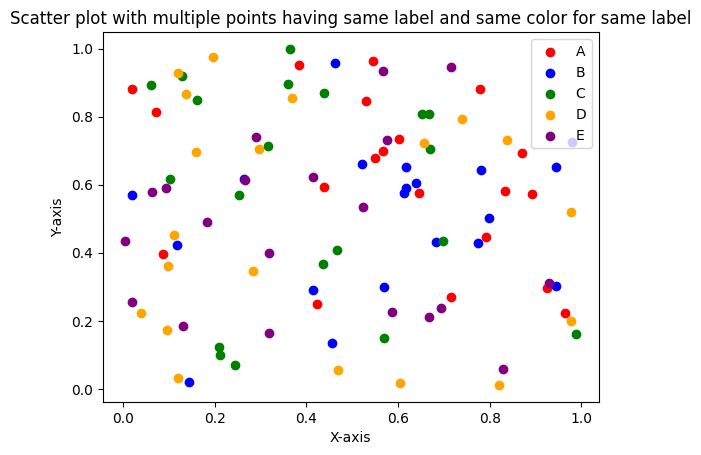

In [270]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data
np.random.seed(0)
num_points_per_label = 20
x = np.random.rand(5 * num_points_per_label)
y = np.random.rand(5 * num_points_per_label)
labels = ['A', 'B', 'C', 'D', 'E']
colors = ['red', 'blue', 'green', 'orange', 'purple']

label_data = np.repeat(labels, num_points_per_label)

# Create a scatter plot with different markers for each label group
for label, color in zip(labels, colors):
    idx = label_data == label
    plt.scatter(x[idx], y[idx], color=color, label=label)

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter plot with multiple points having same label and same color for same label')

# Add a legend
plt.legend()

# Show the plot
plt.show()
